## Initial model

C:\Users\JYW\Anaconda3\lib\site-packages\pybo\domains\domains.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for (a, b) in bounds])).T
C:\Users\JYW\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: UserWarning: parameters lie outside prior support; clipping values


Iteration: 0


<Figure size 864x216 with 0 Axes>

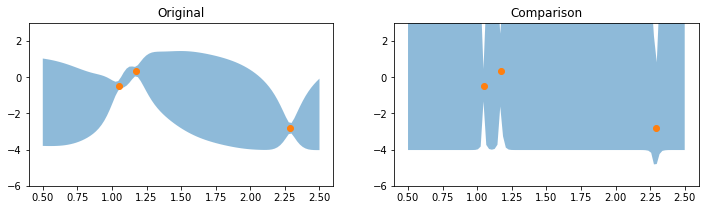

In [110]:
# from __future__ import division
# from __future__ import absolute_import
# from __future__ import print_function
# 위 코드는 python2에서도 3 기능을 쓰기 위함이다.
# 본 simulation은 python3에서 작업하였으므로 필요없는 code.

"""
Animated demo showing progress of Bayesian optimization on a simple
(but highly multimodal) one-dimensional function.
"""

import numpy as np
import reggie as rg
from reggie import models
from matplotlib import pyplot as ez

from pybo.bayesopt import IndexPolicy, RecPolicy
from pybo.domains import Grid

%matplotlib inline

__all__ = []


def f(x):
    """
    Test function we'll optimize. This is a 1d, sinusoidal function used by
    Gramacy and Lee in "Cases for the nugget in modeling computer experiments".
    """
    x = float(x)
    return -np.sin(10*np.pi*x) / (2*x) - (x-1)**4


# define the bounds over which we'll optimize, the optimal x for
# comparison, and a sequence of test points
bounds = [0.5, 2.5]
xopt = 0.54856343
fopt = f(xopt)
fopt

# create the domain
domain = Grid(bounds, 100)
domain

# policy choices: PI, EI, UCB, Thompson, PES, IPES
policy_name = 'PES'

# pybo.policies simple.py 에 계산식 있음.
if policy_name == 'PES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': False})
elif policy_name == 'IPES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': True})
else:
    policy = IndexPolicy(domain, policy_name)

# pybo recommenders.py 에 계산식 있음.
recommender = RecPolicy(domain, 'observed')

# get initial data and some test points.
def init(self, method='latin', rng=None, **kwargs):
        return continuous.INITS[method](self.bounds, rng=rng, **kwargs)

X_init = list(domain.init())
Y_init = [f(x_) for x_ in X_init]
F_init = []

from copy import copy
X = copy(X_init)
Y = copy(Y_init)
F = copy(F_init)

X2 = copy(X_init)
Y2 = copy(Y_init)
F2 = copy(F_init)

# initialize the model
model = models.make_gp(0.01, 1.9, 0.1, 0)
model2 =  models.make_gp(10000, 1.9, 0.1, 0)

# 순서대로 sn2, rho, ell, mean
# random하게 나타나는듯. MCMC 과정에서 random한 결과가 영향을 주는듯
# sn2 조정:
# rho 조정:
# ell 조정:

# set the priors and make the model sample over hyperparameters
model.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model.params['mean']['bias'].prior = rg.core.priors.Normal(0, 20)

model2.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model2.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model2.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model2.params['mean']['bias'].prior = rg.core.priors.Normal(0, 20)

# make a meta-model to sample over models; add data
model = models.MCMC(model, n=10, skip=True)
model.add_data(X, Y)

model2 = models.MCMC(model2, n=10, skip=True)
model2.add_data(X2, Y2)


# grab a figure
fig = ez.figure(figsize=(12, 3))

n_iters = 1
for i in range(n_iters):
    print('Iteration: ' + str(i))
    fig = ez.figure(figsize=(12, 3))

    # PLOT EVERYTHING
    ax1 = ez.subplot2grid((1, 2), (0, 0))
    ax2 = ez.subplot2grid((1, 2), (0, 1))
#     ax3 = ez.subplot2grid((2, 2), (0, 1), rowspan=2)
#     ax1.get_xaxis().set_visible(False)
    
    # evaluate the posterior before updating the model for plotting
    mu, s2 = model.predict(domain.X)
    mu2, s22 = model2.predict(domain.X)
    
    # plot the posterior and data
    ax1.fill_between(domain.X.ravel(), mu + (2*np.sqrt(s2)), mu - (2*np.sqrt(s2)), alpha=0.5)
    ax1.scatter(np.ravel(X), Y)
    ax1.set_ylim(-6, 3)
    ax1.set_title('Original')

 # plot the posterior and data
    ax2.fill_between(domain.X.ravel(), mu2 + (2*np.sqrt(s22)), mu2 - (2*np.sqrt(s22)), alpha=0.5)
    ax2.scatter(np.ravel(X2), Y2)
    ax2.set_ylim(-6, 3)
    ax2.set_title('Comparison')
    
    # get the recommendation and the next query
    xbest = recommender(model, X, Y)
    xnext = policy(model, X)
    ynext = f(xnext)
    
    xbest2 = recommender(model2, X2, Y2)
    xnext2 = policy(model2, X2)
    ynext2 = f(xnext2)

    # evaluate the posterior before updating the model for plotting
    mu, s2 = model.predict(domain.X)
    mu2, s22 = model2.predict(domain.X)

    
    # record our data and update the model
    X.append(xnext)
    Y.append(ynext)
    F.append(f(xbest))
    model.add_data(xnext, ynext)
    
    X2.append(xnext2)
    Y2.append(ynext2)
    F2.append(f(xbest2))
    model2.add_data(xnext2, ynext2)

    # draw
    fig.canvas.draw()
    ez.show(block=False)

## 2. Prior

#### 2-1. 같은 데이터 포인트에 대한 GP (with 다른 prior)

C:\Users\JYW\Anaconda3\lib\site-packages\pybo\domains\domains.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for (a, b) in bounds])).T


Iteration: 0


<Figure size 864x216 with 0 Axes>

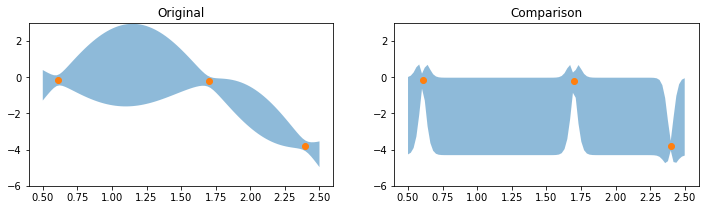

Iteration: 1


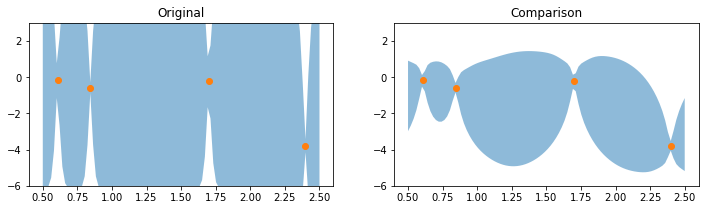

Iteration: 2


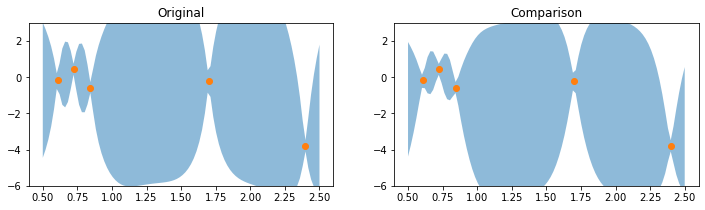

Iteration: 3


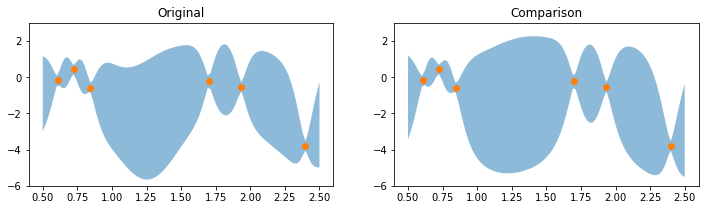

Iteration: 4


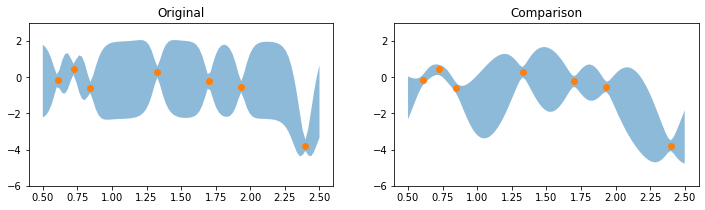

Iteration: 5


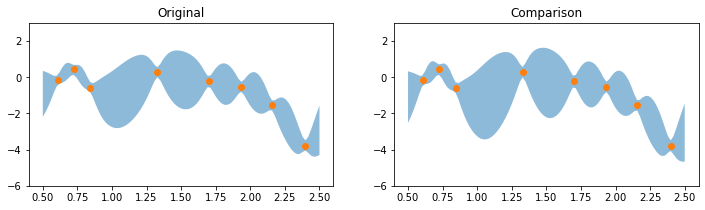

Iteration: 6


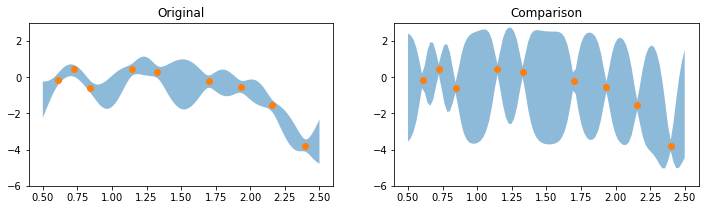

Iteration: 7


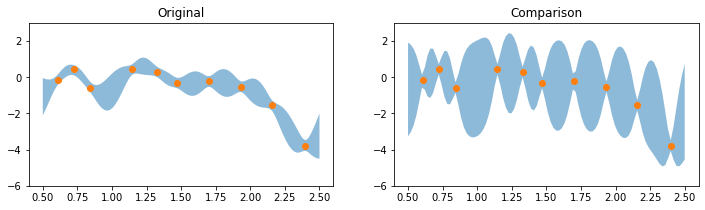

Iteration: 8


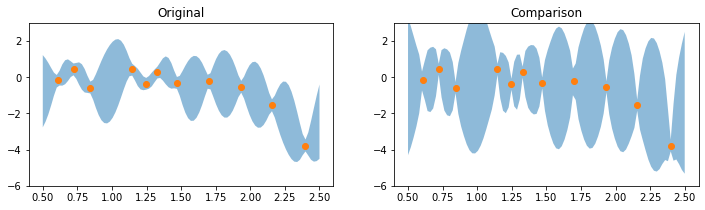

Iteration: 9


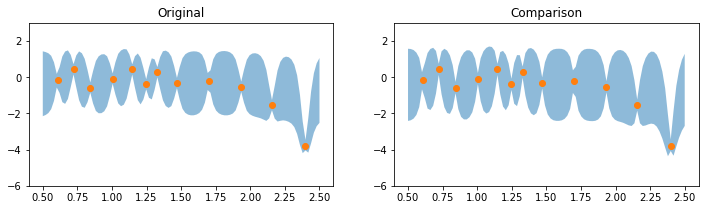

In [111]:
# from __future__ import division
# from __future__ import absolute_import
# from __future__ import print_function
# 위 코드는 python2에서도 3 기능을 쓰기 위함이다.
# 본 simulation은 python3에서 작업하였으므로 필요없는 code.

"""
Animated demo showing progress of Bayesian optimization on a simple
(but highly multimodal) one-dimensional function.
"""

import numpy as np
import reggie as rg
from reggie import models
from matplotlib import pyplot as ez

from pybo.bayesopt import IndexPolicy, RecPolicy
from pybo.domains import Grid

%matplotlib inline

__all__ = []


def f(x):
    """
    Test function we'll optimize. This is a 1d, sinusoidal function used by
    Gramacy and Lee in "Cases for the nugget in modeling computer experiments".
    """
    x = float(x)
    return -np.sin(10*np.pi*x) / (2*x) - (x-1)**4


# define the bounds over which we'll optimize, the optimal x for
# comparison, and a sequence of test points
bounds = [0.5, 2.5]
xopt = 0.54856343
fopt = f(xopt)
fopt

# create the domain
domain = Grid(bounds, 100)
domain

# policy choices: PI, EI, UCB, Thompson, PES, IPES
policy_name = 'PES'

# pybo.policies simple.py 에 계산식 있음.
if policy_name == 'PES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': False})
elif policy_name == 'IPES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': True})
else:
    policy = IndexPolicy(domain, policy_name)

# pybo recommenders.py 에 계산식 있음.
recommender = RecPolicy(domain, 'observed')

# get initial data and some test points.
def init(self, method='latin', rng=None, **kwargs):
        return continuous.INITS[method](self.bounds, rng=rng, **kwargs)

X_init = list(domain.init())
Y_init = [f(x_) for x_ in X_init]
F_init = []

from copy import copy
X = copy(X_init)
Y = copy(Y_init)
F = copy(F_init)

X2 = copy(X_init)
Y2 = copy(Y_init)
F2 = copy(F_init)

# initialize the model
model = models.make_gp(0.01, 1.9, 0.1, 0)
model2 =  models.make_gp(0.01, 1.9, 0.1, 0)


# set the priors and make the model sample over hyperparameters
model.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model.params['mean']['bias'].prior = rg.core.priors.Normal(0, 20)

model2.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model2.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model2.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model2.params['mean']['bias'].prior = rg.core.priors.Normal(0, 2000)

# sn2를 넓게 하면 유니폼한 영역 / 좁게하면 좁은 영역


# make a meta-model to sample over models; add data
model = models.MCMC(model, n=10, skip=True)
model.add_data(X, Y)

model2 = models.MCMC(model2, n=10, skip=True)
model2.add_data(X2, Y2)


# grab a figure
fig = ez.figure(figsize=(12, 3))

n_iters = 10
for i in range(n_iters):
    print('Iteration: ' + str(i))
    fig = ez.figure(figsize=(12, 3))

    # PLOT EVERYTHING
    ax1 = ez.subplot2grid((1, 2), (0, 0))
    ax2 = ez.subplot2grid((1, 2), (0, 1))
#     ax3 = ez.subplot2grid((2, 2), (0, 1), rowspan=2)
#     ax1.get_xaxis().set_visible(False)
    
    # evaluate the posterior before updating the model for plotting
    mu, s2 = model.predict(domain.X)
    mu2, s22 = model2.predict(domain.X)
    
    # plot the posterior and data
    ax1.fill_between(domain.X.ravel(), mu + (2*np.sqrt(s2)), mu - (2*np.sqrt(s2)), alpha=0.5)
    ax1.scatter(np.ravel(X), Y)
    ax1.set_ylim(-6, 3)
    ax1.set_title('Original')

 # plot the posterior and data
    ax2.fill_between(domain.X.ravel(), mu2 + (2*np.sqrt(s22)), mu2 - (2*np.sqrt(s22)), alpha=0.5)
    ax2.scatter(np.ravel(X2), Y2)
    ax2.set_ylim(-6, 3)
    ax2.set_title('Comparison')
    
    # get the recommendation and the next query
    xbest = recommender(model, X, Y)
    xnext = policy(model, X)
    ynext = f(xnext)
    
    xbest2 = recommender(model2, X2, Y2)
    xnext2 = policy(model2, X2)
    ynext2 = f(xnext2)
    
    # record our data and update the model
    X.append(xnext)
    Y.append(ynext)
    F.append(f(xbest))
    model.add_data(xnext, ynext)
    
    X2.append(xnext)
    Y2.append(ynext)
    F2.append(f(xbest))
    model2.add_data(xnext, ynext)

    # draw
    fig.canvas.draw()
    ez.show(block=False)

#### 2-2. Next data point도 다르게!

C:\Users\JYW\Anaconda3\lib\site-packages\pybo\domains\domains.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for (a, b) in bounds])).T


Iteration: 0


<Figure size 864x216 with 0 Axes>

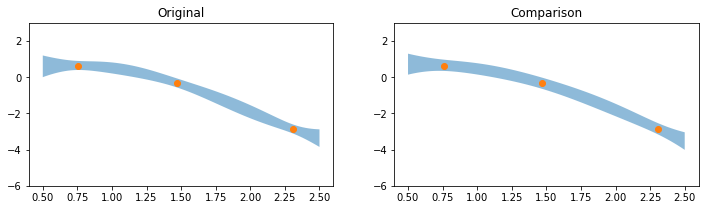

Iteration: 1


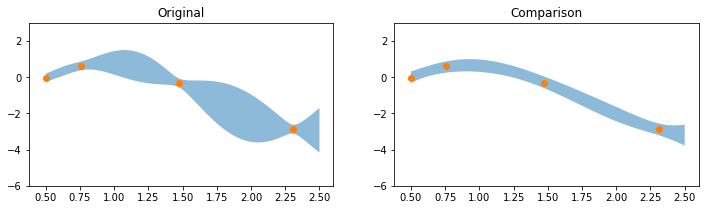

Iteration: 2


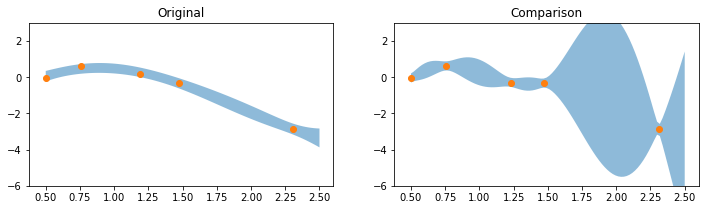

Iteration: 3


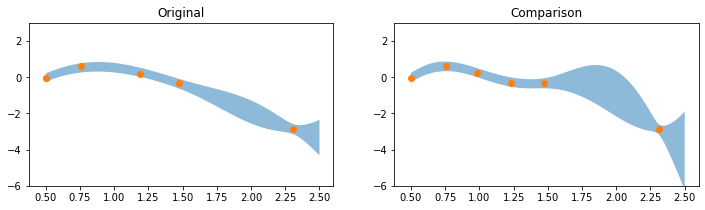

Iteration: 4


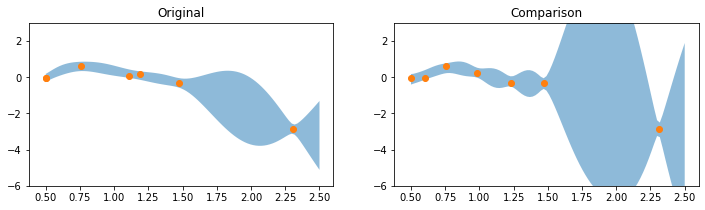

Iteration: 5


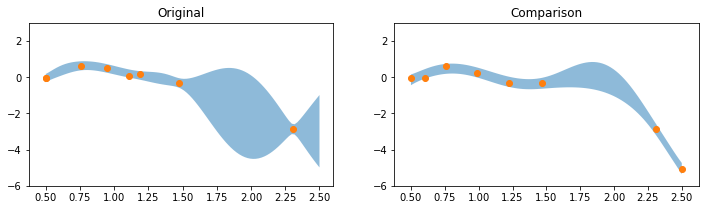

Iteration: 6


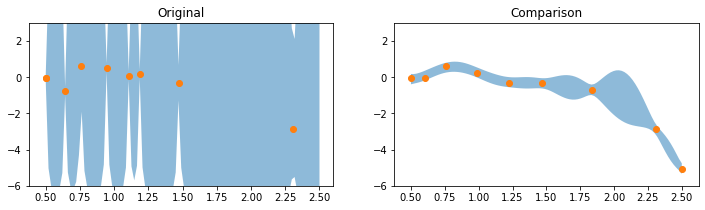

Iteration: 7


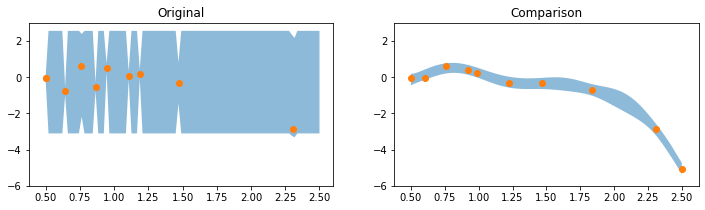

Iteration: 8


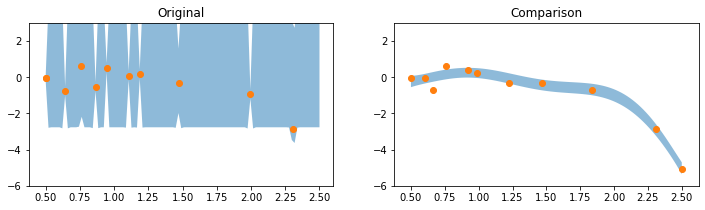

Iteration: 9


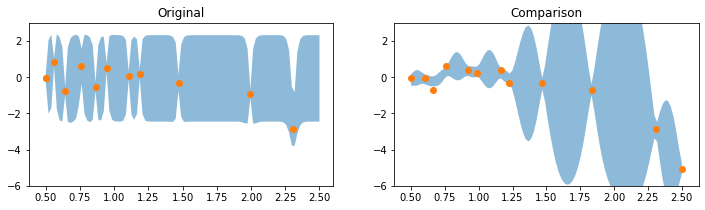

In [112]:
# from __future__ import division
# from __future__ import absolute_import
# from __future__ import print_function
# 위 코드는 python2에서도 3 기능을 쓰기 위함이다.
# 본 simulation은 python3에서 작업하였으므로 필요없는 code.

"""
Animated demo showing progress of Bayesian optimization on a simple
(but highly multimodal) one-dimensional function.
"""

import numpy as np
import reggie as rg
from reggie import models
from matplotlib import pyplot as ez

from pybo.bayesopt import IndexPolicy, RecPolicy
from pybo.domains import Grid

%matplotlib inline

__all__ = []


def f(x):
    """
    Test function we'll optimize. This is a 1d, sinusoidal function used by
    Gramacy and Lee in "Cases for the nugget in modeling computer experiments".
    """
    x = float(x)
    return -np.sin(10*np.pi*x) / (2*x) - (x-1)**4


# define the bounds over which we'll optimize, the optimal x for
# comparison, and a sequence of test points
bounds = [0.5, 2.5]
xopt = 0.54856343
fopt = f(xopt)
fopt

# create the domain
domain = Grid(bounds, 100)
domain

# policy choices: PI, EI, UCB, Thompson, PES, IPES
policy_name = 'PES'

# pybo.policies simple.py 에 계산식 있음.
if policy_name == 'PES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': False})
elif policy_name == 'IPES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': True})
else:
    policy = IndexPolicy(domain, policy_name)

# pybo recommenders.py 에 계산식 있음.
recommender = RecPolicy(domain, 'observed')

# get initial data and some test points.
def init(self, method='latin', rng=None, **kwargs):
        return continuous.INITS[method](self.bounds, rng=rng, **kwargs)

X_init = list(domain.init())
Y_init = [f(x_) for x_ in X_init]
F_init = []

from copy import copy
X = copy(X_init)
Y = copy(Y_init)
F = copy(F_init)

X2 = copy(X_init)
Y2 = copy(Y_init)
F2 = copy(F_init)

# initialize the model
model = models.make_gp(0.01, 1.9, 0.1, 0)
model2 =  models.make_gp(0.01, 1.9, 0.1, 0)


# set the priors and make the model sample over hyperparameters
model.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model.params['mean']['bias'].prior = rg.core.priors.Normal(0, 20)

model2.params['like']['sn2'].prior = rg.core.priors.Uniform(0.005, 0.015)
model2.params['kern']['rho'].prior = rg.core.priors.LogNormal(0, 100)
model2.params['kern']['ell'].prior = rg.core.priors.LogNormal(0, 10)
model2.params['mean']['bias'].prior = rg.core.priors.Normal(0, 2000)

# sn2를 넓게 하면 유니폼한 영역 / 좁게하면 좁은 영역


# make a meta-model to sample over models; add data
model = models.MCMC(model, n=10, skip=True)
model.add_data(X, Y)

model2 = models.MCMC(model2, n=10, skip=True)
model2.add_data(X2, Y2)


# grab a figure
fig = ez.figure(figsize=(12, 3))

n_iters = 10
for i in range(n_iters):
    print('Iteration: ' + str(i))
    fig = ez.figure(figsize=(12, 3))

    # PLOT EVERYTHING
    ax1 = ez.subplot2grid((1, 2), (0, 0))
    ax2 = ez.subplot2grid((1, 2), (0, 1))
#     ax3 = ez.subplot2grid((2, 2), (0, 1), rowspan=2)
#     ax1.get_xaxis().set_visible(False)
    
    # evaluate the posterior before updating the model for plotting
    mu, s2 = model.predict(domain.X)
    mu2, s22 = model2.predict(domain.X)
    
    # plot the posterior and data
    ax1.fill_between(domain.X.ravel(), mu + (2*np.sqrt(s2)), mu - (2*np.sqrt(s2)), alpha=0.5)
    ax1.scatter(np.ravel(X), Y)
    ax1.set_ylim(-6, 3)
    ax1.set_title('Original')

 # plot the posterior and data
    ax2.fill_between(domain.X.ravel(), mu2 + (2*np.sqrt(s22)), mu2 - (2*np.sqrt(s22)), alpha=0.5)
    ax2.scatter(np.ravel(X2), Y2)
    ax2.set_ylim(-6, 3)
    ax2.set_title('Comparison')
    
    # get the recommendation and the next query
    xbest = recommender(model, X, Y)
    xnext = policy(model, X)
    ynext = f(xnext)
    
    xbest2 = recommender(model2, X2, Y2)
    xnext2 = policy(model2, X2)
    ynext2 = f(xnext2)
    
    # record our data and update the model
    X.append(xnext)
    Y.append(ynext)
    F.append(f(xbest))
    model.add_data(xnext, ynext)
    
    X2.append(xnext2)
    Y2.append(ynext2)
    F2.append(f(xbest2))
    model2.add_data(xnext2, ynext2)

    # draw
    fig.canvas.draw()
    ez.show(block=False)

## 전체적인 총평

* Random setting이 어떻게 되느냐에 따라 계속 바뀌는 그림이 나타남
* 이 case에서는 일반적인 경향성을 따지기는 쉽지 않음
* iteration이 늘어나면 전체적으로 비슷해지는 것 같음